<a href="https://colab.research.google.com/github/cocozhang98/ECE1512_2022W_ProjectRepo_Coco_Zhang/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import numpy as np
import matplotlib.pyplot as plt

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data loading

In [ ]:

# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Model creation

In [ ]:
#@test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
cnn_model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, input_shape=(28, 28, 1), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=1))
cnn_model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=2))
cnn_model.add(Flatten())
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Dense(10))

# Build fully connected student.
fc_model = tf.keras.Sequential()

# your code start from here for step 2
fc_model.add(Flatten(input_shape=(28, 28, 1)))
fc_model.add(Dense(784, activation='relu'))
fc_model.add(Dense(784, activation='relu'))
fc_model.add(Dense(10))


# Loss Functions

## Teacher loss function

In [ ]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits))

  return cross_entropy_loss_value

## Student loss function

In [ ]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits/temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits))

  return ALPHA * distillation_loss_value + (1 - ALPHA) * cross_entropy_loss_value

# Train and evaluation

In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables) #see https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
  

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model, images, labels)[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
  return (num_correct / num_total * 100).numpy()


# Training models

The teacher model is first trained.

In [ ]:
# your code start from here for step 5 

train_and_evaluate(cnn_model, compute_teacher_loss)



Epoch 1: Class_accuracy: 98.13%
Epoch 2: Class_accuracy: 98.66%
Epoch 3: Class_accuracy: 98.73%
Epoch 4: Class_accuracy: 98.91%
Epoch 5: Class_accuracy: 98.90%
Epoch 6: Class_accuracy: 98.91%
Epoch 7: Class_accuracy: 99.08%
Epoch 8: Class_accuracy: 99.13%
Epoch 9: Class_accuracy: 99.07%
Epoch 10: Class_accuracy: 99.07%
Epoch 11: Class_accuracy: 99.07%
Epoch 12: Class_accuracy: 99.22%


<tf.Tensor: shape=(), dtype=float32, numpy=99.22>

Now that we have the teacher model trained, we need to train and test the student models.

When training, it was found that the final test accuracy would change from model initialization and batch randomization. Thus, for each hyperparameter, the student model is trained 5 times. To plot, the mean and standard deviation for accuracies are used. 

## Training the student model for alpha = 0.5, T = 1,2,4,16,32,64

In [ ]:
accuracy = []
std = []

In [ ]:
ALPHA = 0.5
DISTILLATION_TEMPERATURE = 1.

accuracy_1 = []

for i in range(5):
  fc_model = tf.keras.Sequential()

  # your code start from here for step 2
  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(10))
  accuracy_1.append(train_and_evaluate(fc_model, compute_student_loss))

accuracy.append(np.mean(accuracy_1))
std.append(np.std(accuracy_1))

Epoch 1: Class_accuracy: 96.78%
Epoch 2: Class_accuracy: 97.56%
Epoch 3: Class_accuracy: 97.71%
Epoch 4: Class_accuracy: 97.94%
Epoch 5: Class_accuracy: 98.18%
Epoch 6: Class_accuracy: 98.33%
Epoch 7: Class_accuracy: 98.31%
Epoch 8: Class_accuracy: 98.20%
Epoch 9: Class_accuracy: 98.31%
Epoch 10: Class_accuracy: 98.44%
Epoch 11: Class_accuracy: 98.15%
Epoch 12: Class_accuracy: 98.26%
Epoch 1: Class_accuracy: 96.73%
Epoch 2: Class_accuracy: 97.56%
Epoch 3: Class_accuracy: 97.76%
Epoch 4: Class_accuracy: 97.53%
Epoch 5: Class_accuracy: 98.17%
Epoch 6: Class_accuracy: 98.19%
Epoch 7: Class_accuracy: 98.17%
Epoch 8: Class_accuracy: 98.30%
Epoch 9: Class_accuracy: 98.34%
Epoch 10: Class_accuracy: 98.20%
Epoch 11: Class_accuracy: 98.16%
Epoch 12: Class_accuracy: 98.26%
Epoch 1: Class_accuracy: 96.75%
Epoch 2: Class_accuracy: 97.73%
Epoch 3: Class_accuracy: 97.86%
Epoch 4: Class_accuracy: 97.99%
Epoch 5: Class_accuracy: 98.27%
Epoch 6: Class_accuracy: 98.04%
Epoch 7: Class_accuracy: 98.23%
Ep

In [ ]:
ALPHA = 0.5
DISTILLATION_TEMPERATURE = 2.

accuracy_2 = []

for i in range(5):
  fc_model = tf.keras.Sequential()

  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(10))
  accuracy_2.append(train_and_evaluate(fc_model, compute_student_loss))

accuracy.append(np.mean(accuracy_2))
std.append(np.std(accuracy_2))

Epoch 1: Class_accuracy: 96.29%
Epoch 2: Class_accuracy: 97.69%
Epoch 3: Class_accuracy: 98.05%
Epoch 4: Class_accuracy: 98.37%
Epoch 5: Class_accuracy: 98.31%
Epoch 6: Class_accuracy: 98.54%
Epoch 7: Class_accuracy: 98.47%
Epoch 8: Class_accuracy: 98.64%
Epoch 9: Class_accuracy: 98.54%
Epoch 10: Class_accuracy: 98.46%
Epoch 11: Class_accuracy: 98.56%
Epoch 12: Class_accuracy: 98.62%
Epoch 1: Class_accuracy: 96.40%
Epoch 2: Class_accuracy: 97.41%
Epoch 3: Class_accuracy: 97.99%
Epoch 4: Class_accuracy: 98.23%
Epoch 5: Class_accuracy: 98.26%
Epoch 6: Class_accuracy: 98.51%
Epoch 7: Class_accuracy: 98.64%
Epoch 8: Class_accuracy: 98.61%
Epoch 9: Class_accuracy: 98.39%
Epoch 10: Class_accuracy: 98.57%
Epoch 11: Class_accuracy: 98.77%
Epoch 12: Class_accuracy: 98.53%
Epoch 1: Class_accuracy: 96.67%
Epoch 2: Class_accuracy: 97.76%
Epoch 3: Class_accuracy: 98.21%
Epoch 4: Class_accuracy: 98.31%
Epoch 5: Class_accuracy: 98.33%
Epoch 6: Class_accuracy: 98.55%
Epoch 7: Class_accuracy: 98.45%
Ep

In [ ]:
ALPHA = 0.5
DISTILLATION_TEMPERATURE = 4.

accuracy_4 = []

for i in range(5):
  fc_model = tf.keras.Sequential()

  # your code start from here for step 2
  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(10))
  accuracy_4.append(train_and_evaluate(fc_model, compute_student_loss))

accuracy.append(np.mean(accuracy_4))
std.append(np.std(accuracy_4))

Epoch 1: Class_accuracy: 96.72%
Epoch 2: Class_accuracy: 97.95%
Epoch 3: Class_accuracy: 98.21%
Epoch 4: Class_accuracy: 98.37%
Epoch 5: Class_accuracy: 98.40%
Epoch 6: Class_accuracy: 98.60%
Epoch 7: Class_accuracy: 98.73%
Epoch 8: Class_accuracy: 98.69%
Epoch 9: Class_accuracy: 98.69%
Epoch 10: Class_accuracy: 98.71%
Epoch 11: Class_accuracy: 98.71%
Epoch 12: Class_accuracy: 98.81%
Epoch 1: Class_accuracy: 96.54%
Epoch 2: Class_accuracy: 97.79%
Epoch 3: Class_accuracy: 98.38%
Epoch 4: Class_accuracy: 98.40%
Epoch 5: Class_accuracy: 98.61%
Epoch 6: Class_accuracy: 98.66%
Epoch 7: Class_accuracy: 98.73%
Epoch 8: Class_accuracy: 98.74%
Epoch 9: Class_accuracy: 98.78%
Epoch 10: Class_accuracy: 98.85%
Epoch 11: Class_accuracy: 98.79%
Epoch 12: Class_accuracy: 98.85%
Epoch 1: Class_accuracy: 96.78%
Epoch 2: Class_accuracy: 97.96%
Epoch 3: Class_accuracy: 98.35%
Epoch 4: Class_accuracy: 98.38%
Epoch 5: Class_accuracy: 98.56%
Epoch 6: Class_accuracy: 98.75%
Epoch 7: Class_accuracy: 98.73%
Ep

In [ ]:
ALPHA = 0.5
DISTILLATION_TEMPERATURE = 16.

accuracy_16 = []

for i in range(5):
  fc_model = tf.keras.Sequential()

  # your code start from here for step 2
  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(10))
  accuracy_16.append(train_and_evaluate(fc_model, compute_student_loss))

accuracy.append(np.mean(accuracy_16))
std.append(np.std(accuracy_16))

Epoch 1: Class_accuracy: 96.74%
Epoch 2: Class_accuracy: 97.76%
Epoch 3: Class_accuracy: 98.28%
Epoch 4: Class_accuracy: 98.36%
Epoch 5: Class_accuracy: 98.62%
Epoch 6: Class_accuracy: 98.60%
Epoch 7: Class_accuracy: 98.66%
Epoch 8: Class_accuracy: 98.71%
Epoch 9: Class_accuracy: 98.71%
Epoch 10: Class_accuracy: 98.69%
Epoch 11: Class_accuracy: 98.74%
Epoch 12: Class_accuracy: 98.72%
Epoch 1: Class_accuracy: 96.52%
Epoch 2: Class_accuracy: 97.70%
Epoch 3: Class_accuracy: 98.14%
Epoch 4: Class_accuracy: 98.39%
Epoch 5: Class_accuracy: 98.57%
Epoch 6: Class_accuracy: 98.57%
Epoch 7: Class_accuracy: 98.62%
Epoch 8: Class_accuracy: 98.75%
Epoch 9: Class_accuracy: 98.77%
Epoch 10: Class_accuracy: 98.82%
Epoch 11: Class_accuracy: 98.72%
Epoch 12: Class_accuracy: 98.89%
Epoch 1: Class_accuracy: 96.65%
Epoch 2: Class_accuracy: 97.84%
Epoch 3: Class_accuracy: 98.29%
Epoch 4: Class_accuracy: 98.47%
Epoch 5: Class_accuracy: 98.57%
Epoch 6: Class_accuracy: 98.57%
Epoch 7: Class_accuracy: 98.61%
Ep

In [ ]:
ALPHA = 0.5
DISTILLATION_TEMPERATURE = 32.
accuracy_32 = []

for i in range(5):
  fc_model = tf.keras.Sequential()

  # your code start from here for step 2
  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(10))
  accuracy_32.append(train_and_evaluate(fc_model, compute_student_loss))

accuracy.append(np.mean(accuracy_32))
std.append(np.std(accuracy_32))

Epoch 1: Class_accuracy: 96.74%
Epoch 2: Class_accuracy: 97.79%
Epoch 3: Class_accuracy: 98.28%
Epoch 4: Class_accuracy: 98.40%
Epoch 5: Class_accuracy: 98.59%
Epoch 6: Class_accuracy: 98.61%
Epoch 7: Class_accuracy: 98.70%
Epoch 8: Class_accuracy: 98.64%
Epoch 9: Class_accuracy: 98.79%
Epoch 10: Class_accuracy: 98.79%
Epoch 11: Class_accuracy: 98.85%
Epoch 12: Class_accuracy: 98.91%
Epoch 1: Class_accuracy: 96.86%
Epoch 2: Class_accuracy: 97.92%
Epoch 3: Class_accuracy: 98.30%
Epoch 4: Class_accuracy: 98.51%
Epoch 5: Class_accuracy: 98.54%
Epoch 6: Class_accuracy: 98.70%
Epoch 7: Class_accuracy: 98.66%
Epoch 8: Class_accuracy: 98.66%
Epoch 9: Class_accuracy: 98.70%
Epoch 10: Class_accuracy: 98.74%
Epoch 11: Class_accuracy: 98.78%
Epoch 12: Class_accuracy: 98.80%
Epoch 1: Class_accuracy: 96.81%
Epoch 2: Class_accuracy: 97.69%
Epoch 3: Class_accuracy: 98.22%
Epoch 4: Class_accuracy: 98.34%
Epoch 5: Class_accuracy: 98.48%
Epoch 6: Class_accuracy: 98.59%
Epoch 7: Class_accuracy: 98.62%
Ep

In [ ]:
ALPHA = 0.5
DISTILLATION_TEMPERATURE = 64.
accuracy_64 = []

for i in range(5):
  fc_model = tf.keras.Sequential()

  # your code start from here for step 2
  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(10))
  accuracy_64.append(train_and_evaluate(fc_model, compute_student_loss))

accuracy.append(np.mean(accuracy_64))
std.append(np.std(accuracy_64))

Epoch 1: Class_accuracy: 96.89%
Epoch 2: Class_accuracy: 97.99%
Epoch 3: Class_accuracy: 98.33%
Epoch 4: Class_accuracy: 98.46%
Epoch 5: Class_accuracy: 98.57%
Epoch 6: Class_accuracy: 98.60%
Epoch 7: Class_accuracy: 98.75%
Epoch 8: Class_accuracy: 98.71%
Epoch 9: Class_accuracy: 98.82%
Epoch 10: Class_accuracy: 98.77%
Epoch 11: Class_accuracy: 98.79%
Epoch 12: Class_accuracy: 98.75%
Epoch 1: Class_accuracy: 96.81%
Epoch 2: Class_accuracy: 97.97%
Epoch 3: Class_accuracy: 98.24%
Epoch 4: Class_accuracy: 98.47%
Epoch 5: Class_accuracy: 98.66%
Epoch 6: Class_accuracy: 98.68%
Epoch 7: Class_accuracy: 98.70%
Epoch 8: Class_accuracy: 98.76%
Epoch 9: Class_accuracy: 98.80%
Epoch 10: Class_accuracy: 98.83%
Epoch 11: Class_accuracy: 98.81%
Epoch 12: Class_accuracy: 98.80%
Epoch 1: Class_accuracy: 96.78%
Epoch 2: Class_accuracy: 97.94%
Epoch 3: Class_accuracy: 98.19%
Epoch 4: Class_accuracy: 98.43%
Epoch 5: Class_accuracy: 98.52%
Epoch 6: Class_accuracy: 98.60%
Epoch 7: Class_accuracy: 98.67%
Ep

In [ ]:
accuracy

[98.327995, 98.577995, 98.812, 98.814, 98.832, 98.75399]

In [ ]:
std

[0.067351855, 0.030592872, 0.029933026, 0.057479598, 0.05035723, 0.0300653]

## Tuning Hyperparameters for best performance student model

In [ ]:
ALPHA = 0.75
DISTILLATION_TEMPERATURE = 16.
accuracy_alpha_75 = []

for i in range(5):
  print("Training: %d/5" % (i))
  fc_model = tf.keras.Sequential()

  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(10))
  accuracy_alpha_75.append(train_and_evaluate(fc_model, compute_student_loss))
print("Average Final Test Accuracy: %f" % (np.mean(accuracy_alpha_75)))
print("")


Training: 0/5
Epoch 1: Class_accuracy: 96.55%
Epoch 2: Class_accuracy: 97.75%
Epoch 3: Class_accuracy: 98.33%
Epoch 4: Class_accuracy: 98.38%
Epoch 5: Class_accuracy: 98.60%
Epoch 6: Class_accuracy: 98.64%
Epoch 7: Class_accuracy: 98.63%
Epoch 8: Class_accuracy: 98.75%
Epoch 9: Class_accuracy: 98.76%
Epoch 10: Class_accuracy: 98.73%
Epoch 11: Class_accuracy: 98.73%
Epoch 12: Class_accuracy: 98.85%
Training: 1/5
Epoch 1: Class_accuracy: 96.58%
Epoch 2: Class_accuracy: 97.85%
Epoch 3: Class_accuracy: 98.16%
Epoch 4: Class_accuracy: 98.44%
Epoch 5: Class_accuracy: 98.44%
Epoch 6: Class_accuracy: 98.59%
Epoch 7: Class_accuracy: 98.68%
Epoch 8: Class_accuracy: 98.73%
Epoch 9: Class_accuracy: 98.74%
Epoch 10: Class_accuracy: 98.77%
Epoch 11: Class_accuracy: 98.86%
Epoch 12: Class_accuracy: 98.77%
Training: 2/5
Epoch 1: Class_accuracy: 96.56%
Epoch 2: Class_accuracy: 97.77%
Epoch 3: Class_accuracy: 98.13%
Epoch 4: Class_accuracy: 98.33%
Epoch 5: Class_accuracy: 98.58%
Epoch 6: Class_accuracy:

In [ ]:
ALPHA = 0.25
DISTILLATION_TEMPERATURE = 16.
accuracy_alpha_25 = []

for i in range(5):
  print("Training: %d/5" % (i))
  fc_model = tf.keras.Sequential()

  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(10))
  accuracy_alpha_25.append(train_and_evaluate(fc_model, compute_student_loss))
print("Average Final Test Accuracy: %f" % (np.mean(accuracy_alpha_25)))
print("")


Training: 0/5
Epoch 1: Class_accuracy: 96.88%
Epoch 2: Class_accuracy: 97.84%
Epoch 3: Class_accuracy: 98.26%
Epoch 4: Class_accuracy: 98.48%
Epoch 5: Class_accuracy: 98.55%
Epoch 6: Class_accuracy: 98.65%
Epoch 7: Class_accuracy: 98.66%
Epoch 8: Class_accuracy: 98.66%
Epoch 9: Class_accuracy: 98.73%
Epoch 10: Class_accuracy: 98.77%
Epoch 11: Class_accuracy: 98.79%
Epoch 12: Class_accuracy: 98.66%
Training: 1/5
Epoch 1: Class_accuracy: 96.76%
Epoch 2: Class_accuracy: 97.94%
Epoch 3: Class_accuracy: 98.33%
Epoch 4: Class_accuracy: 98.42%
Epoch 5: Class_accuracy: 98.58%
Epoch 6: Class_accuracy: 98.67%
Epoch 7: Class_accuracy: 98.67%
Epoch 8: Class_accuracy: 98.67%
Epoch 9: Class_accuracy: 98.71%
Epoch 10: Class_accuracy: 98.71%
Epoch 11: Class_accuracy: 98.73%
Epoch 12: Class_accuracy: 98.81%
Training: 2/5
Epoch 1: Class_accuracy: 96.93%
Epoch 2: Class_accuracy: 97.89%
Epoch 3: Class_accuracy: 98.35%
Epoch 4: Class_accuracy: 98.50%
Epoch 5: Class_accuracy: 98.60%
Epoch 6: Class_accuracy:

In [ ]:
ALPHA = 0.75
DISTILLATION_TEMPERATURE = 32.
accuracy_alpha_75_32 = []

for i in range(5):
  print("Training: %d/5" % (i))
  fc_model = tf.keras.Sequential()

  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(10))
  accuracy_alpha_75_32.append(train_and_evaluate(fc_model, compute_student_loss))
print("Average Final Test Accuracy: %f" % (np.mean(accuracy_alpha_75_32)))
print("")


Training: 0/5
Epoch 1: Class_accuracy: 96.57%
Epoch 2: Class_accuracy: 97.65%
Epoch 3: Class_accuracy: 98.07%
Epoch 4: Class_accuracy: 98.21%
Epoch 5: Class_accuracy: 98.29%
Epoch 6: Class_accuracy: 98.45%
Epoch 7: Class_accuracy: 98.53%
Epoch 8: Class_accuracy: 98.52%
Epoch 9: Class_accuracy: 98.64%
Epoch 10: Class_accuracy: 98.63%
Epoch 11: Class_accuracy: 98.70%
Epoch 12: Class_accuracy: 98.62%
Training: 1/5
Epoch 1: Class_accuracy: 96.56%
Epoch 2: Class_accuracy: 97.75%
Epoch 3: Class_accuracy: 98.11%
Epoch 4: Class_accuracy: 98.31%
Epoch 5: Class_accuracy: 98.52%
Epoch 6: Class_accuracy: 98.53%
Epoch 7: Class_accuracy: 98.62%
Epoch 8: Class_accuracy: 98.66%
Epoch 9: Class_accuracy: 98.66%
Epoch 10: Class_accuracy: 98.64%
Epoch 11: Class_accuracy: 98.76%
Epoch 12: Class_accuracy: 98.72%
Training: 2/5
Epoch 1: Class_accuracy: 96.69%
Epoch 2: Class_accuracy: 97.67%
Epoch 3: Class_accuracy: 98.24%
Epoch 4: Class_accuracy: 98.34%
Epoch 5: Class_accuracy: 98.50%
Epoch 6: Class_accuracy:

In [ ]:
ALPHA = 0.25
DISTILLATION_TEMPERATURE = 32.
accuracy_alpha_25_32 = []

for i in range(5):
  print("Training: %d/5" % (i))
  fc_model = tf.keras.Sequential()

  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(10))
  accuracy_alpha_25_32.append(train_and_evaluate(fc_model, compute_student_loss))
print("Average Final Test Accuracy: %f" % (np.mean(accuracy_alpha_25_32)))
print("")


Training: 0/5
Epoch 1: Class_accuracy: 96.77%
Epoch 2: Class_accuracy: 97.98%
Epoch 3: Class_accuracy: 98.29%
Epoch 4: Class_accuracy: 98.52%
Epoch 5: Class_accuracy: 98.64%
Epoch 6: Class_accuracy: 98.61%
Epoch 7: Class_accuracy: 98.73%
Epoch 8: Class_accuracy: 98.73%
Epoch 9: Class_accuracy: 98.73%
Epoch 10: Class_accuracy: 98.80%
Epoch 11: Class_accuracy: 98.82%
Epoch 12: Class_accuracy: 98.86%
Training: 1/5
Epoch 1: Class_accuracy: 96.73%
Epoch 2: Class_accuracy: 97.95%
Epoch 3: Class_accuracy: 98.36%
Epoch 4: Class_accuracy: 98.63%
Epoch 5: Class_accuracy: 98.63%
Epoch 6: Class_accuracy: 98.63%
Epoch 7: Class_accuracy: 98.70%
Epoch 8: Class_accuracy: 98.77%
Epoch 9: Class_accuracy: 98.73%
Epoch 10: Class_accuracy: 98.88%
Epoch 11: Class_accuracy: 98.81%
Epoch 12: Class_accuracy: 98.82%
Training: 2/5
Epoch 1: Class_accuracy: 97.00%
Epoch 2: Class_accuracy: 98.05%
Epoch 3: Class_accuracy: 98.35%
Epoch 4: Class_accuracy: 98.57%
Epoch 5: Class_accuracy: 98.62%
Epoch 6: Class_accuracy:

In [ ]:
ALPHA = 0.4
DISTILLATION_TEMPERATURE = 32.
accuracy_alpha_4_32 = []

for i in range(5):
  print("Training: %d/5" % (i))
  fc_model = tf.keras.Sequential()

  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(10))
  accuracy_alpha_4_32.append(train_and_evaluate(fc_model, compute_student_loss))
print("Average Final Test Accuracy: %f" % (np.mean(accuracy_alpha_4_32)))
print("")


Training: 0/5
Epoch 1: Class_accuracy: 96.98%
Epoch 2: Class_accuracy: 98.15%
Epoch 3: Class_accuracy: 98.33%
Epoch 4: Class_accuracy: 98.49%
Epoch 5: Class_accuracy: 98.56%
Epoch 6: Class_accuracy: 98.55%
Epoch 7: Class_accuracy: 98.80%
Epoch 8: Class_accuracy: 98.72%
Epoch 9: Class_accuracy: 98.66%
Epoch 10: Class_accuracy: 98.89%
Epoch 11: Class_accuracy: 98.83%
Epoch 12: Class_accuracy: 98.74%
Training: 1/5
Epoch 1: Class_accuracy: 96.75%
Epoch 2: Class_accuracy: 97.91%
Epoch 3: Class_accuracy: 98.18%
Epoch 4: Class_accuracy: 98.51%
Epoch 5: Class_accuracy: 98.57%
Epoch 6: Class_accuracy: 98.60%
Epoch 7: Class_accuracy: 98.72%
Epoch 8: Class_accuracy: 98.65%
Epoch 9: Class_accuracy: 98.77%
Epoch 10: Class_accuracy: 98.72%
Epoch 11: Class_accuracy: 98.83%
Epoch 12: Class_accuracy: 98.75%
Training: 2/5
Epoch 1: Class_accuracy: 96.79%
Epoch 2: Class_accuracy: 97.99%
Epoch 3: Class_accuracy: 98.27%
Epoch 4: Class_accuracy: 98.46%
Epoch 5: Class_accuracy: 98.49%
Epoch 6: Class_accuracy:

In [ ]:
ALPHA = 0.6
DISTILLATION_TEMPERATURE = 32.
accuracy_alpha_6_32 = []

for i in range(5):
  print("Training: %d/5" % (i))
  fc_model = tf.keras.Sequential()

  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(10))
  accuracy_alpha_6_32.append(train_and_evaluate(fc_model, compute_student_loss))
print("Average Final Test Accuracy: %f" % (np.mean(accuracy_alpha_6_32)))
print("")


Training: 0/5
Epoch 1: Class_accuracy: 96.73%
Epoch 2: Class_accuracy: 97.90%
Epoch 3: Class_accuracy: 98.30%
Epoch 4: Class_accuracy: 98.49%
Epoch 5: Class_accuracy: 98.54%
Epoch 6: Class_accuracy: 98.71%
Epoch 7: Class_accuracy: 98.64%
Epoch 8: Class_accuracy: 98.79%
Epoch 9: Class_accuracy: 98.80%
Epoch 10: Class_accuracy: 98.83%
Epoch 11: Class_accuracy: 98.86%
Epoch 12: Class_accuracy: 98.95%
Training: 1/5
Epoch 1: Class_accuracy: 96.47%
Epoch 2: Class_accuracy: 97.74%
Epoch 3: Class_accuracy: 98.27%
Epoch 4: Class_accuracy: 98.42%
Epoch 5: Class_accuracy: 98.43%
Epoch 6: Class_accuracy: 98.49%
Epoch 7: Class_accuracy: 98.68%
Epoch 8: Class_accuracy: 98.62%
Epoch 9: Class_accuracy: 98.76%
Epoch 10: Class_accuracy: 98.78%
Epoch 11: Class_accuracy: 98.71%
Epoch 12: Class_accuracy: 98.73%
Training: 2/5
Epoch 1: Class_accuracy: 96.76%
Epoch 2: Class_accuracy: 98.02%
Epoch 3: Class_accuracy: 98.25%
Epoch 4: Class_accuracy: 98.43%
Epoch 5: Class_accuracy: 98.57%
Epoch 6: Class_accuracy:

## Notable Final Accuracies

In [ ]:
print("Accuracy for alpha=0.25, T=32: %.3f +/- %.3f" % (np.mean(accuracy_alpha_25_32),np.std(accuracy_alpha_25_32)))
print("Accuracy for alpha=0.4, T=32: %.3f +/- %.3f" % (np.mean(accuracy_alpha_4_32),np.std(accuracy_alpha_4_32)))
print("Accuracy for alpha=0.5, T=32: %.3f +/- %.3f" % (np.mean(accuracy_32),np.std(accuracy_32)))
print("Accuracy for alpha=0.6, T=32: %.3f +/- %.3f" % (np.mean(accuracy_alpha_6_32),np.std(accuracy_alpha_6_32)))
print("Accuracy for alpha=0.75, T=32: %.3f +/- %.3f" % (np.mean(accuracy_alpha_75_32),np.std(accuracy_alpha_75_32)))

Accuracy for alpha=0.25, T=32: 98.824 +/- 0.029
Accuracy for alpha=0.4, T=32: 98.764 +/- 0.034
Accuracy for alpha=0.5, T=32: 98.832 +/- 0.050
Accuracy for alpha=0.6, T=32: 98.782 +/- 0.102
Accuracy for alpha=0.75, T=32: 98.752 +/- 0.075


In [ ]:
print("Accuracy for alpha=0.25, T=16: %.3f +/- %.3f" % (np.mean(accuracy_alpha_25),np.std(accuracy_alpha_25)))
print("Accuracy for alpha=0.5, T=16: %.3f +/- %.3f" % (np.mean(accuracy_16),np.std(accuracy_16)))
print("Accuracy for alpha=0.75, T=16: %.3f +/- %.3f" % (np.mean(accuracy_alpha_75),np.std(accuracy_alpha_75)))

Accuracy for alpha=0.25, T=16: 98.780 +/- 0.075
Accuracy for alpha=0.5, T=16: 98.814 +/- 0.057
Accuracy for alpha=0.75, T=16: 98.754 +/- 0.055


Conclusion: The best hyperparameters are alpha=0.5, T=32. 

# Test accuracy vs. temperature curve

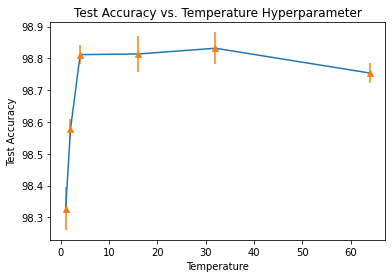

In [ ]:
# your code start from here for step 6
temperature = [1, 2, 4, 16, 32, 64]
accuracy = [98.327995, 98.577995, 98.812, 98.814, 98.832, 98.75399]
std = [0.067351855, 0.030592872, 0.029933026, 0.057479598, 0.05035723, 0.0300653]
plt.plot(temperature, accuracy)

plt.errorbar(temperature, accuracy, std, linestyle='None', marker='^')

plt.xlabel('Temperature')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Temperature Hyperparameter')
plt.show()


# Train student from scratch

In [ ]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7
fc_model_no_distillation.add(Flatten(input_shape=(28, 28, 1)))
fc_model_no_distillation.add(Dense(784, activation='relu'))
fc_model_no_distillation.add(Dense(784, activation='relu'))
fc_model_no_distillation.add(Dense(10))


#@test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits))
  
  return cross_entropy_loss


train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 96.97%
Epoch 2: Class_accuracy: 97.47%
Epoch 3: Class_accuracy: 97.73%
Epoch 4: Class_accuracy: 97.75%
Epoch 5: Class_accuracy: 98.23%
Epoch 6: Class_accuracy: 98.36%
Epoch 7: Class_accuracy: 97.96%
Epoch 8: Class_accuracy: 97.84%
Epoch 9: Class_accuracy: 98.08%
Epoch 10: Class_accuracy: 98.25%
Epoch 11: Class_accuracy: 98.30%
Epoch 12: Class_accuracy: 98.25%


98.25

In [ ]:
accuracy_plain = []

for i in range(5):
  print("Training: %d/5" % (i))
  fc_model_no_distillation = tf.keras.Sequential()

  fc_model_no_distillation.add(Flatten(input_shape=(28, 28, 1)))
  fc_model_no_distillation.add(Dense(784, activation='relu'))
  fc_model_no_distillation.add(Dense(784, activation='relu'))
  fc_model_no_distillation.add(Dense(10))
  accuracy_plain.append(train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss))

print("Average Final Test Accuracy: %f" % (np.mean(accuracy_plain)))
print("")

Training: 0/5
Epoch 1: Class_accuracy: 96.82%
Epoch 2: Class_accuracy: 97.59%
Epoch 3: Class_accuracy: 97.92%
Epoch 4: Class_accuracy: 97.94%
Epoch 5: Class_accuracy: 97.87%
Epoch 6: Class_accuracy: 97.99%
Epoch 7: Class_accuracy: 98.13%
Epoch 8: Class_accuracy: 97.94%
Epoch 9: Class_accuracy: 97.97%
Epoch 10: Class_accuracy: 98.14%
Epoch 11: Class_accuracy: 98.18%
Epoch 12: Class_accuracy: 98.15%
Training: 1/5
Epoch 1: Class_accuracy: 96.59%
Epoch 2: Class_accuracy: 97.62%
Epoch 3: Class_accuracy: 98.00%
Epoch 4: Class_accuracy: 98.04%
Epoch 5: Class_accuracy: 97.84%
Epoch 6: Class_accuracy: 97.93%
Epoch 7: Class_accuracy: 97.54%
Epoch 8: Class_accuracy: 98.03%
Epoch 9: Class_accuracy: 98.09%
Epoch 10: Class_accuracy: 97.91%
Epoch 11: Class_accuracy: 97.91%
Epoch 12: Class_accuracy: 97.75%
Training: 2/5
Epoch 1: Class_accuracy: 96.03%
Epoch 2: Class_accuracy: 97.64%
Epoch 3: Class_accuracy: 98.06%
Epoch 4: Class_accuracy: 98.05%
Epoch 5: Class_accuracy: 97.86%
Epoch 6: Class_accuracy:

In [ ]:
print("Teacher Accuracy: 99.22")
print("Best KD Accuracy: %.3f +/- %.3f" % (np.mean(accuracy_32),np.std(accuracy_32)))
print("Average Final Test Accuracy for Scratch Student: %.3f +/- %.3f" % (np.mean(accuracy_plain), np.std(accuracy_plain)))

Teacher Accuracy: 99.22
Best KD Accuracy: 98.832 +/- 0.050
Average Final Test Accuracy for Scratch Student: 97.992 +/- 0.164


# Comparing the teacher and student model (number of of parameters and FLOPs) 

## Number of parameters:

In [ ]:
# your code start from here for step 8
cnn_model.count_params()

1011466

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dropout (Dropout)           (None, 7744)              0

In [ ]:
fc_model.count_params()

1238730

In [ ]:
fc_model.summary()

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_73 (Flatten)        (None, 784)               0         
                                                                 
 dense_218 (Dense)           (None, 784)               615440    
                                                                 
 dense_219 (Dense)           (None, 784)               615440    
                                                                 
 dense_220 (Dense)           (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


## FLOPs: 
The keras-flops package is used. See https://github.com/tokusumi/keras-flops

Note: This refers to # of operations to run a instance of a model, not the floating-point operations per second written in the assignment instruction (which measures computer performance)

In [ ]:
!pip install keras-flops
from keras_flops import get_flops

     |████████████████████████████████| 462 kB 5.2 MB/s 


In [ ]:
flops = get_flops(cnn_model, batch_size=1)
print(f"FLOPs for teacher model: {flops / 10 ** 9:.03} G")

FLOPs for teacher model: 0.022 G


In [ ]:
flops = get_flops(fc_model, batch_size=1)
print(f"FLOPs for student model: {flops / 10 ** 9:.03} G")

FLOPs for student model: 0.00248 G


# XAI method to explain models

First we need to get thte student with optimal hyperparameters again.

In [ ]:
ALPHA = 0.5
DISTILLATION_TEMPERATURE = 32.


fc_model = tf.keras.Sequential()

# your code start from here for step 2
fc_model.add(Flatten(input_shape=(28, 28, 1)))
fc_model.add(Dense(784, activation='relu'))
fc_model.add(Dense(784, activation='relu'))
fc_model.add(Dense(10))
train_and_evaluate(fc_model, compute_student_loss)


Epoch 1: Class_accuracy: 96.78%
Epoch 2: Class_accuracy: 98.01%
Epoch 3: Class_accuracy: 98.23%
Epoch 4: Class_accuracy: 98.52%
Epoch 5: Class_accuracy: 98.53%
Epoch 6: Class_accuracy: 98.60%
Epoch 7: Class_accuracy: 98.67%
Epoch 8: Class_accuracy: 98.69%
Epoch 9: Class_accuracy: 98.73%
Epoch 10: Class_accuracy: 98.70%
Epoch 11: Class_accuracy: 98.78%
Epoch 12: Class_accuracy: 98.81%


98.81

In [ ]:
# your code start from here for step 9
for images, labels in mnist_test:
  sample_images = images[:1]
  sample_labels = labels[:1]
  break

In [ ]:
sample_images.shape

TensorShape([1, 28, 28, 1])

In [ ]:
def get_gradients(input, model, pred_index):
  image = tf.convert_to_tensor(input,dtype='float32')
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction=model(image)
    gradient = tape.gradient(prediction[:, pred_index],image)
  return gradient

def Integrated_Gradient(input, model, label, num_steps):
  steps = np.linspace(0.,1.,num_steps+1)[1:]
  intermediate_images = np.empty((num_steps,28,28,1))
  for i in range(num_steps):
    intermediate_images[i] = input * steps[i]
  
  gradients = get_gradients(intermediate_images, model, tf.math.argmax(label,axis=1)[0])
  integral_gradients = tf.math.reduce_mean(gradients,axis=0) #Integral of steps is essentially the average
  integral_gradients = input * integral_gradients
  return integral_gradients

def visualize_IG(explanation_map_IG):
  explanation_map_IG_abs_avg = np.average(abs(explanation_map_IG),axis=2)
  explanation_map_IG_abs_avg -= explanation_map_IG_abs_avg.min()
  explanation_map_IG_abs_avg /= explanation_map_IG_abs_avg.max()+10e-30
  return explanation_map_IG_abs_avg


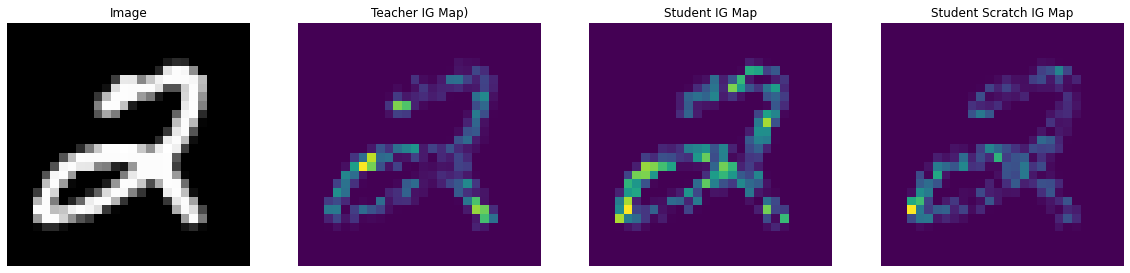

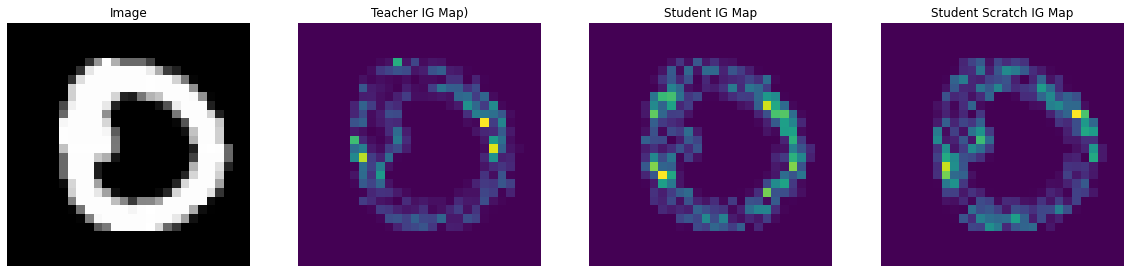

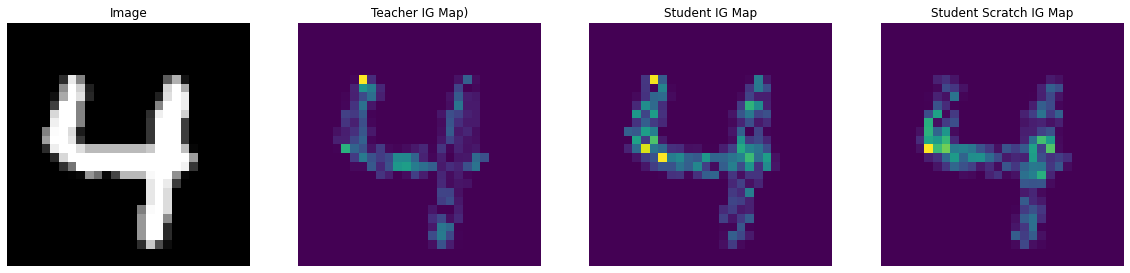

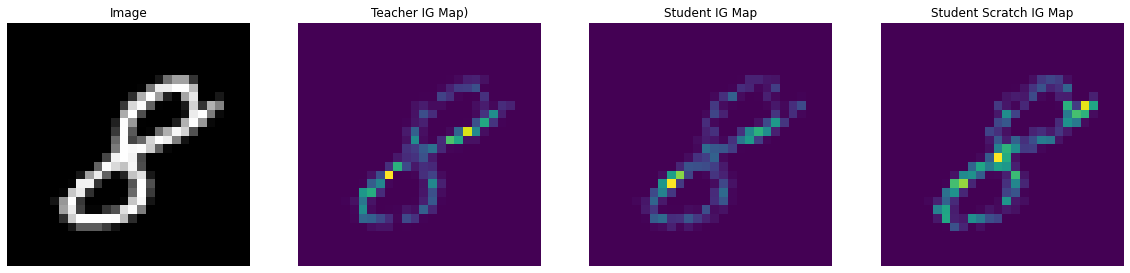

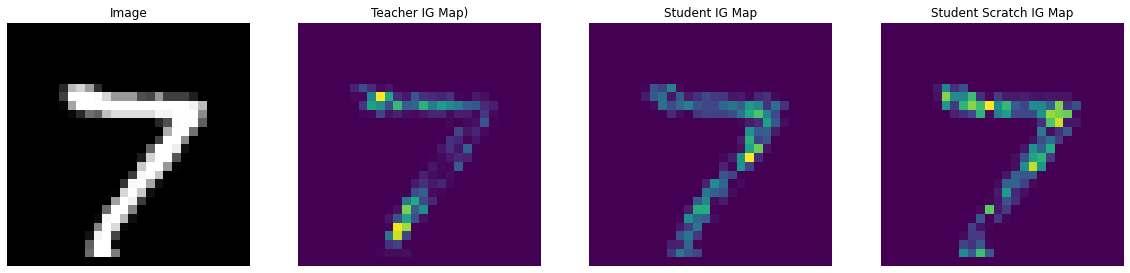

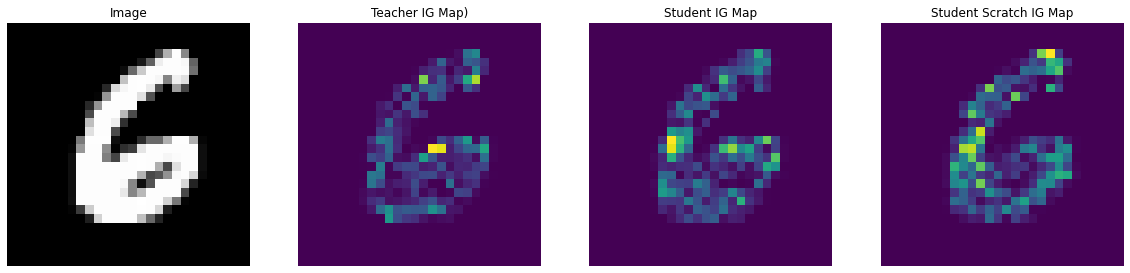

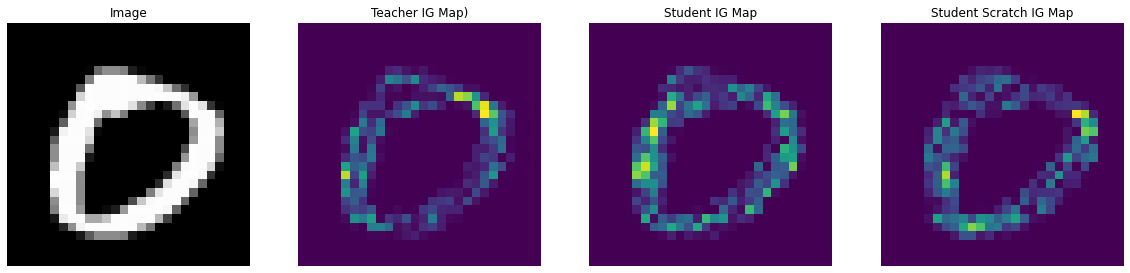

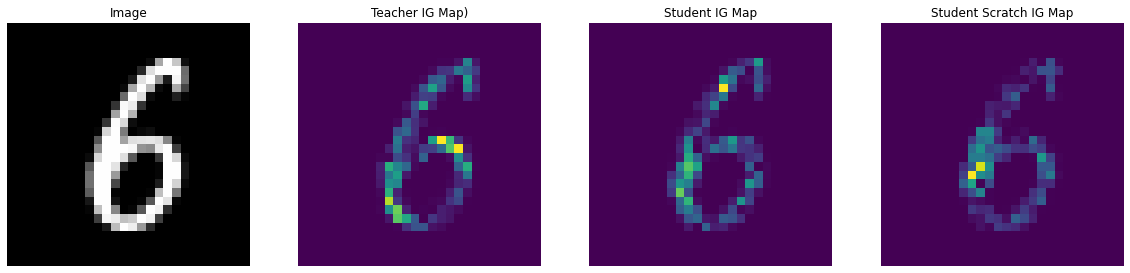

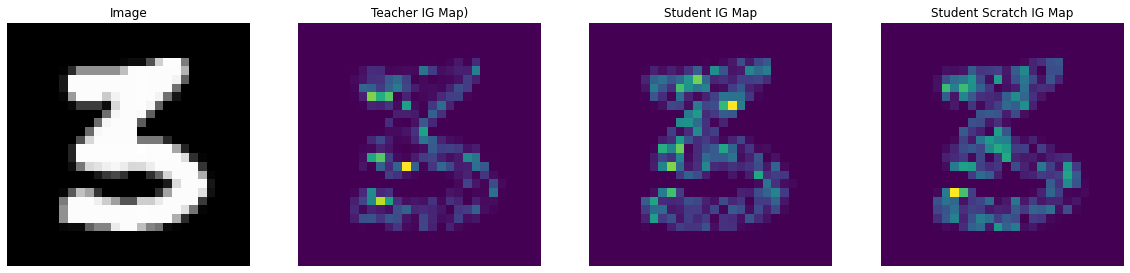

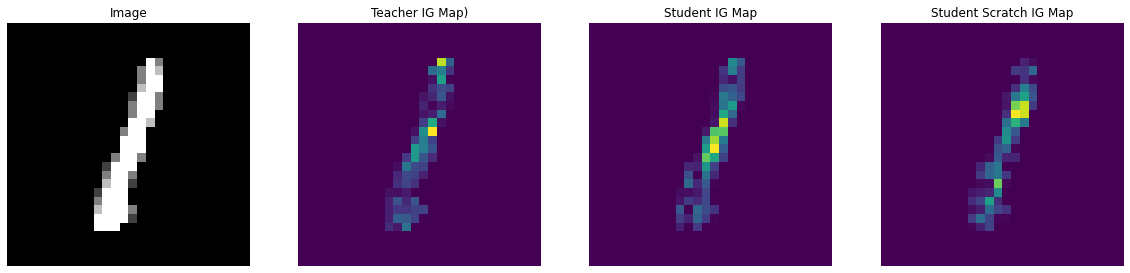

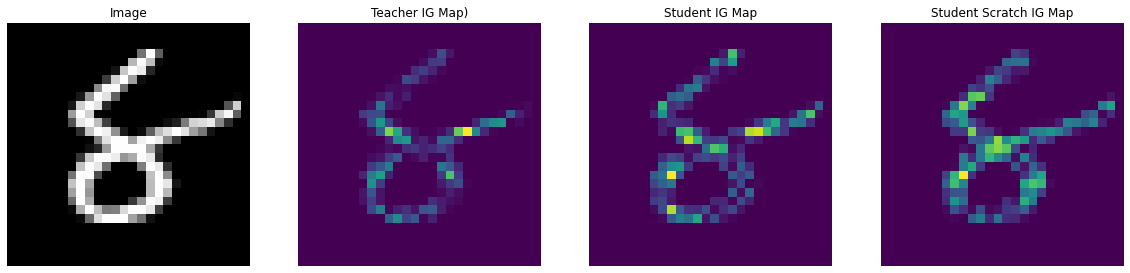

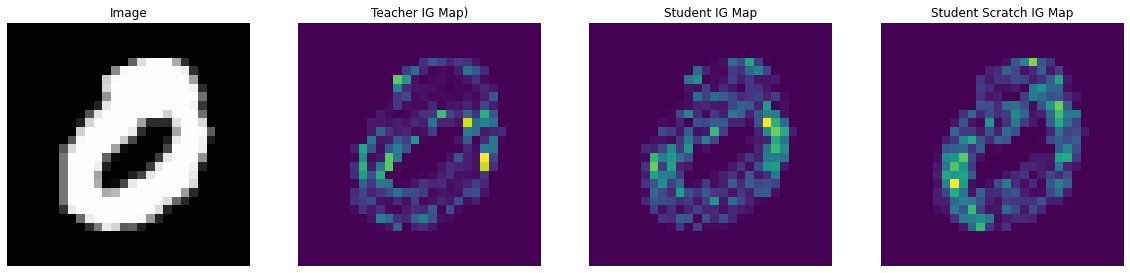

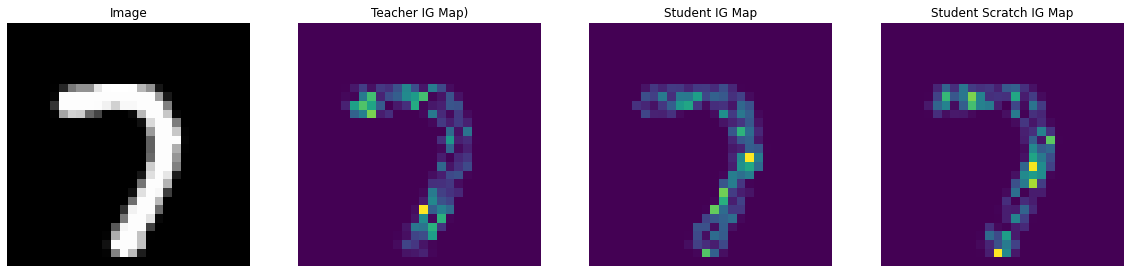

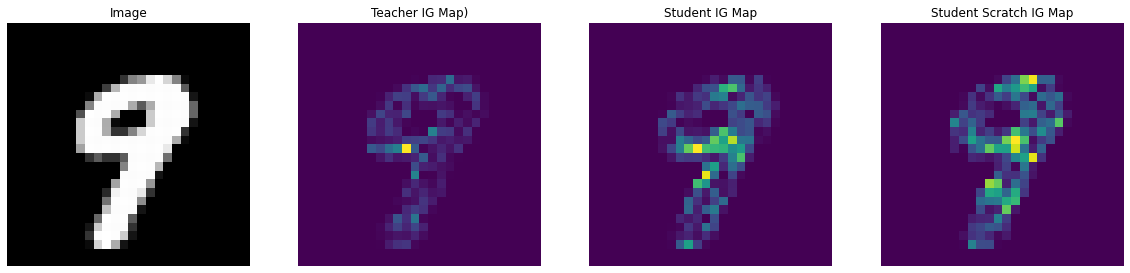

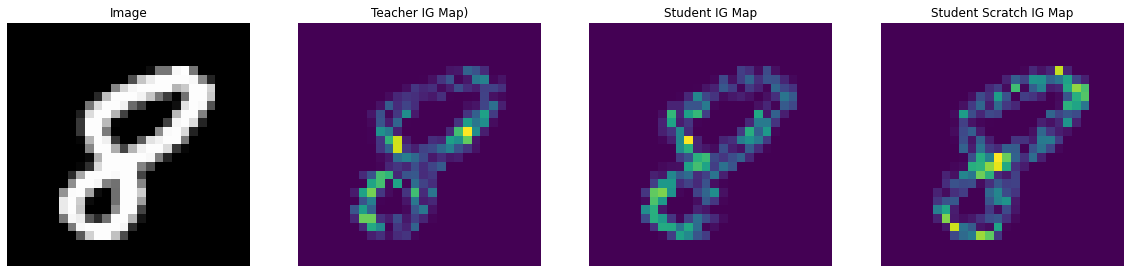

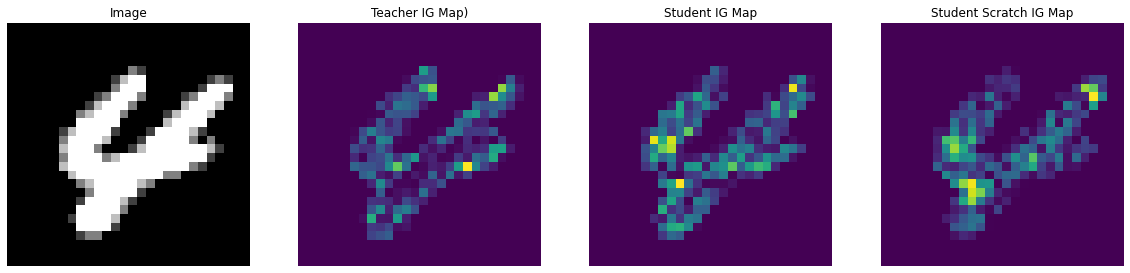

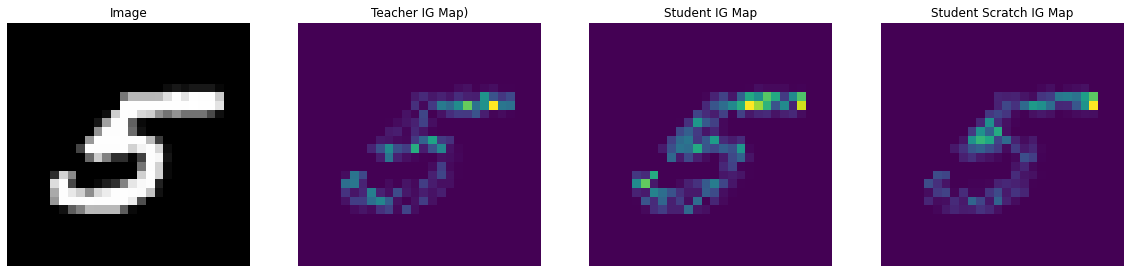

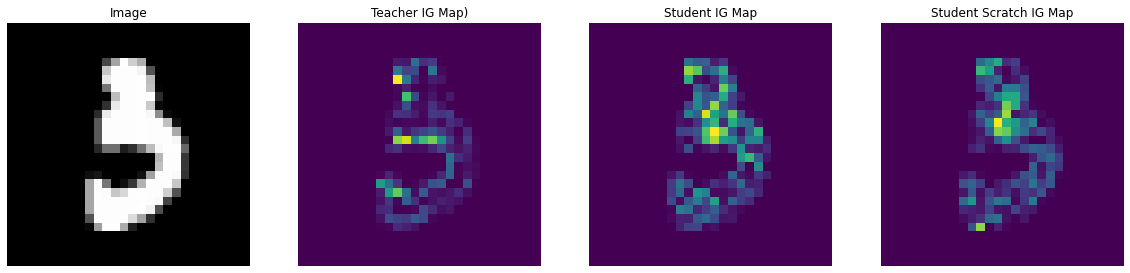

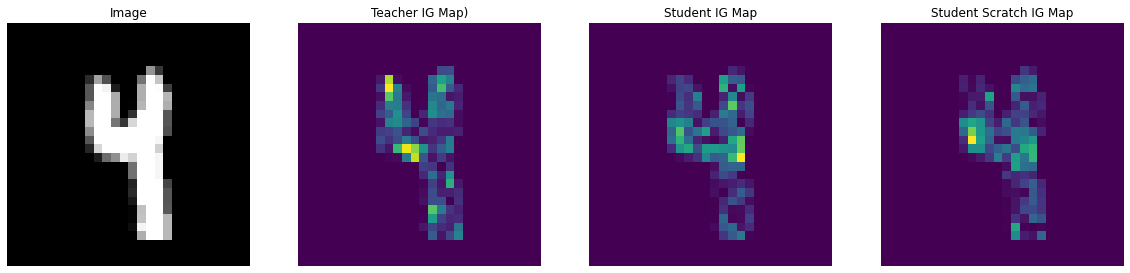

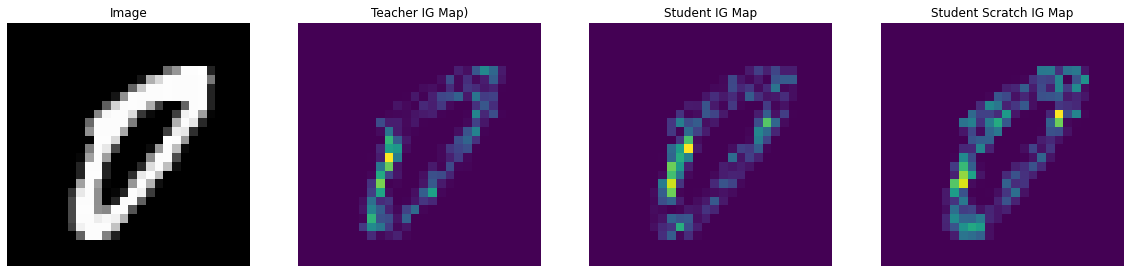

In [ ]:
for i in range(20):
  for images, labels in mnist_test:
    sample_images = images[i:i+1]
    sample_labels = labels[i:i+1]
    break
  IG_teacher = Integrated_Gradient(sample_images,cnn_model,sample_labels,50)
  IG_student = Integrated_Gradient(sample_images,fc_model,sample_labels,50)
  IG_student_scratch = Integrated_Gradient(sample_images,fc_model_no_distillation,sample_labels,50)

  plt.figure(figsize=(20,5))
  plt.subplot(1,4,1)
  plt.imshow(sample_images.numpy().reshape((28,28)),cmap='gray')
  plt.axis('off')
  plt.title('Image')

  plt.subplot(1,4,2)
  plt.imshow(visualize_IG(IG_teacher[0]).reshape((28,28)))
  plt.axis('off')
  plt.title('Teacher IG Map)')

  plt.subplot(1,4,3)
  plt.imshow(visualize_IG(IG_student[0]).reshape((28,28)))
  plt.axis('off')
  plt.title('Student IG Map')

  plt.subplot(1,4,4)
  plt.imshow(visualize_IG(IG_student_scratch[0]).reshape((28,28)))
  plt.axis('off')
  plt.title('Student Scratch IG Map')
  plt.show()

# Implementing the state-of-the-art KD algorithm

KD Algorithm: Teacher Assistant

In [ ]:
# build the teacher again
train_and_evaluate(cnn_model, compute_teacher_loss)

Epoch 1: Class_accuracy: 98.36%
Epoch 2: Class_accuracy: 98.69%
Epoch 3: Class_accuracy: 98.77%
Epoch 4: Class_accuracy: 98.99%
Epoch 5: Class_accuracy: 98.99%
Epoch 6: Class_accuracy: 99.15%
Epoch 7: Class_accuracy: 99.11%
Epoch 8: Class_accuracy: 99.17%
Epoch 9: Class_accuracy: 99.02%
Epoch 10: Class_accuracy: 99.11%
Epoch 11: Class_accuracy: 99.03%
Epoch 12: Class_accuracy: 99.15%


99.15

In [ ]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 16. #temperature hyperparameter

def compute_ta_loss(images, labels):

  ta_subclass_logits = ta_model(images, training=True)

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, ta_subclass_logits, DISTILLATION_TEMPERATURE)

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, ta_subclass_logits))

  return ALPHA * distillation_loss_value + (1 - ALPHA) * cross_entropy_loss_value

In [ ]:
ta_model = tf.keras.Sequential()

ta_model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, input_shape=(28, 28, 1), activation='relu'))
ta_model.add(MaxPooling2D(pool_size=(2,2), strides=1))
ta_model.add(Flatten())
ta_model.add(Dropout(rate=0.5))
ta_model.add(Dense(128, activation='relu'))
ta_model.add(Dropout(rate=0.5))
ta_model.add(Dense(10))

In [ ]:
train_and_evaluate(ta_model,compute_ta_loss)

Epoch 1: Class_accuracy: 96.75%
Epoch 2: Class_accuracy: 97.71%
Epoch 3: Class_accuracy: 98.05%
Epoch 4: Class_accuracy: 98.09%
Epoch 5: Class_accuracy: 98.24%
Epoch 6: Class_accuracy: 98.32%
Epoch 7: Class_accuracy: 98.22%
Epoch 8: Class_accuracy: 98.33%
Epoch 9: Class_accuracy: 98.47%
Epoch 10: Class_accuracy: 98.37%
Epoch 11: Class_accuracy: 98.39%
Epoch 12: Class_accuracy: 98.51%


98.509995

## Tune temperature

In [ ]:
DISTILLATION_TEMPERATURE = 16

accuracy_ta = []

for i in range(5):
  print("Training: %d/5" % (i))
  ta_model = tf.keras.Sequential()

  ta_model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, input_shape=(28, 28, 1), activation='relu'))
  ta_model.add(MaxPooling2D(pool_size=(2,2), strides=1))
  ta_model.add(Flatten())
  ta_model.add(Dropout(rate=0.5))
  ta_model.add(Dense(128, activation='relu'))
  ta_model.add(Dropout(rate=0.5))
  ta_model.add(Dense(10))
  accuracy_ta.append(train_and_evaluate(ta_model, compute_ta_loss))

print("Average Final Test Accuracy: %f" % (np.mean(accuracy_ta)))
print("")


Training: 0/5
Epoch 1: Class_accuracy: 96.91%
Epoch 2: Class_accuracy: 97.94%
Epoch 3: Class_accuracy: 98.07%
Epoch 4: Class_accuracy: 98.09%
Epoch 5: Class_accuracy: 98.29%
Epoch 6: Class_accuracy: 98.32%
Epoch 7: Class_accuracy: 98.33%
Epoch 8: Class_accuracy: 98.32%
Epoch 9: Class_accuracy: 98.37%
Epoch 10: Class_accuracy: 98.42%
Epoch 11: Class_accuracy: 98.40%
Epoch 12: Class_accuracy: 98.40%
Training: 1/5
Epoch 1: Class_accuracy: 96.91%
Epoch 2: Class_accuracy: 97.87%
Epoch 3: Class_accuracy: 98.08%
Epoch 4: Class_accuracy: 98.30%
Epoch 5: Class_accuracy: 98.23%
Epoch 6: Class_accuracy: 98.30%
Epoch 7: Class_accuracy: 98.27%
Epoch 8: Class_accuracy: 98.40%
Epoch 9: Class_accuracy: 98.40%
Epoch 10: Class_accuracy: 98.41%
Epoch 11: Class_accuracy: 98.44%
Epoch 12: Class_accuracy: 98.50%
Training: 2/5
Epoch 1: Class_accuracy: 96.91%
Epoch 2: Class_accuracy: 97.80%
Epoch 3: Class_accuracy: 98.04%
Epoch 4: Class_accuracy: 98.19%
Epoch 5: Class_accuracy: 98.19%
Epoch 6: Class_accuracy:

In [ ]:
DISTILLATION_TEMPERATURE = 32

accuracy_ta = []

for i in range(5):
  print("Training: %d/5" % (i))
  ta_model = tf.keras.Sequential()

  ta_model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, input_shape=(28, 28, 1), activation='relu'))
  ta_model.add(MaxPooling2D(pool_size=(2,2), strides=1))
  ta_model.add(Flatten())
  ta_model.add(Dropout(rate=0.5))
  ta_model.add(Dense(128, activation='relu'))
  ta_model.add(Dropout(rate=0.5))
  ta_model.add(Dense(10))
  accuracy_ta.append(train_and_evaluate(ta_model, compute_ta_loss))

print("Average Final Test Accuracy: %f" % (np.mean(accuracy_ta)))
print("")


Training: 0/5
Epoch 1: Class_accuracy: 96.72%
Epoch 2: Class_accuracy: 97.80%
Epoch 3: Class_accuracy: 98.00%
Epoch 4: Class_accuracy: 98.13%
Epoch 5: Class_accuracy: 98.22%
Epoch 6: Class_accuracy: 98.19%
Epoch 7: Class_accuracy: 98.30%
Epoch 8: Class_accuracy: 98.33%
Epoch 9: Class_accuracy: 98.36%
Epoch 10: Class_accuracy: 98.34%
Epoch 11: Class_accuracy: 98.46%
Epoch 12: Class_accuracy: 98.49%
Training: 1/5
Epoch 1: Class_accuracy: 96.89%
Epoch 2: Class_accuracy: 97.86%
Epoch 3: Class_accuracy: 97.97%
Epoch 4: Class_accuracy: 98.25%
Epoch 5: Class_accuracy: 98.14%
Epoch 6: Class_accuracy: 98.29%
Epoch 7: Class_accuracy: 98.37%
Epoch 8: Class_accuracy: 98.40%
Epoch 9: Class_accuracy: 98.35%
Epoch 10: Class_accuracy: 98.46%
Epoch 11: Class_accuracy: 98.41%
Epoch 12: Class_accuracy: 98.51%
Training: 2/5
Epoch 1: Class_accuracy: 97.25%
Epoch 2: Class_accuracy: 97.90%
Epoch 3: Class_accuracy: 98.03%
Epoch 4: Class_accuracy: 98.13%
Epoch 5: Class_accuracy: 98.24%
Epoch 6: Class_accuracy:

In [ ]:
def compute_student_ta_loss(images, labels):

  student_ta_subclass_logits = fc_model(images, training=True)

  teacher_subclass_logits = ta_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_ta_subclass_logits, DISTILLATION_TEMPERATURE)

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_ta_subclass_logits))

  return ALPHA * distillation_loss_value + (1 - ALPHA) * cross_entropy_loss_value

In [45]:
DISTILLATION_TEMPERATURE = 16
accuracy_student = []

for i in range(5):
  print("Training: %d/5" % (i))
  fc_model = tf.keras.Sequential()

  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(10))
  accuracy_student.append(train_and_evaluate(fc_model, compute_student_ta_loss))

print("Average Final Test Accuracy: %f" % (np.mean(accuracy_student)))
print("")

Training: 0/5
Epoch 1: Class_accuracy: 96.53%
Epoch 2: Class_accuracy: 97.56%
Epoch 3: Class_accuracy: 97.91%
Epoch 4: Class_accuracy: 98.04%
Epoch 5: Class_accuracy: 98.23%
Epoch 6: Class_accuracy: 98.14%
Epoch 7: Class_accuracy: 98.30%
Epoch 8: Class_accuracy: 98.31%
Epoch 9: Class_accuracy: 98.30%
Epoch 10: Class_accuracy: 98.43%
Epoch 11: Class_accuracy: 98.36%
Epoch 12: Class_accuracy: 98.37%
Training: 1/5
Epoch 1: Class_accuracy: 96.35%
Epoch 2: Class_accuracy: 97.49%
Epoch 3: Class_accuracy: 97.80%
Epoch 4: Class_accuracy: 98.02%
Epoch 5: Class_accuracy: 98.00%
Epoch 6: Class_accuracy: 98.12%
Epoch 7: Class_accuracy: 98.15%
Epoch 8: Class_accuracy: 98.27%
Epoch 9: Class_accuracy: 98.20%
Epoch 10: Class_accuracy: 98.29%
Epoch 11: Class_accuracy: 98.33%
Epoch 12: Class_accuracy: 98.32%
Training: 2/5
Epoch 1: Class_accuracy: 96.49%
Epoch 2: Class_accuracy: 97.36%
Epoch 3: Class_accuracy: 97.70%
Epoch 4: Class_accuracy: 97.97%
Epoch 5: Class_accuracy: 98.11%
Epoch 6: Class_accuracy:

In [46]:
DISTILLATION_TEMPERATURE = 32
accuracy_student = []

for i in range(5):
  print("Training: %d/5" % (i))
  fc_model = tf.keras.Sequential()

  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(10))
  accuracy_student.append(train_and_evaluate(fc_model, compute_student_ta_loss))

print("Average Final Test Accuracy: %f" % (np.mean(accuracy_student)))
print("")

Training: 0/5
Epoch 1: Class_accuracy: 96.60%
Epoch 2: Class_accuracy: 97.50%
Epoch 3: Class_accuracy: 97.75%
Epoch 4: Class_accuracy: 97.97%
Epoch 5: Class_accuracy: 98.17%
Epoch 6: Class_accuracy: 98.22%
Epoch 7: Class_accuracy: 98.22%
Epoch 8: Class_accuracy: 98.33%
Epoch 9: Class_accuracy: 98.36%
Epoch 10: Class_accuracy: 98.46%
Epoch 11: Class_accuracy: 98.35%
Epoch 12: Class_accuracy: 98.39%
Training: 1/5
Epoch 1: Class_accuracy: 96.61%
Epoch 2: Class_accuracy: 97.29%
Epoch 3: Class_accuracy: 97.87%
Epoch 4: Class_accuracy: 98.00%
Epoch 5: Class_accuracy: 98.09%
Epoch 6: Class_accuracy: 98.14%
Epoch 7: Class_accuracy: 98.18%
Epoch 8: Class_accuracy: 98.21%
Epoch 9: Class_accuracy: 98.27%
Epoch 10: Class_accuracy: 98.26%
Epoch 11: Class_accuracy: 98.31%
Epoch 12: Class_accuracy: 98.34%
Training: 2/5
Epoch 1: Class_accuracy: 96.52%
Epoch 2: Class_accuracy: 97.34%
Epoch 3: Class_accuracy: 97.83%
Epoch 4: Class_accuracy: 98.07%
Epoch 5: Class_accuracy: 98.17%
Epoch 6: Class_accuracy:

In [ ]:
ta_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 20000)             0         
                                                                 
 dropout (Dropout)           (None, 20000)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               2560128   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

In [47]:
flops = get_flops(ta_model, batch_size=1)

In [ ]:
!pip install keras-flops
from keras_flops import get_flops